In [1]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

In [2]:
import os
import random
import shutil
import numpy as np

import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, MultiRNNCell, DropoutWrapper

from helpers import Indexer, batch
from itertools import chain, product

### Prepare data

In [3]:
SHARED_SIZE = 2 # size of noise (or, common vocab for all types).

TYPES = ['ANIMAL','VEHICLE','NATURE','FURNITURE','FRUIT']
SHARED_VOCAB = ['share'+str(i+1) for i in range(SHARED_SIZE)]
TYPE2VOCAB = {'ANIMAL': ['cat','dog','pig','horse','deer']            + SHARED_VOCAB,
              'VEHICLE': ['car','bike','motorcycle','train','bus']    + SHARED_VOCAB,
              'NATURE': ['hill','mountain','lake','river','valley']   + SHARED_VOCAB,
              'FURNITURE': ['stool','table','closet','cabinet','bed'] + SHARED_VOCAB,
              'FRUIT': ['apple','pear','strawberry','grape','tomato'] + SHARED_VOCAB}
VOCAB = list(chain.from_iterable(TYPE2VOCAB.values()))

indexer = Indexer()
indexer.get_index('PAD')
for word in VOCAB:
    indexer.get_index(word)

In [4]:
DOC_LEN = 5
SENT_FROM_LEN = 5
SENT_TO_LEN = 15
CTX_LEN = ((SENT_TO_LEN-SENT_FROM_LEN)//2)*DOC_LEN

def to_sent(code):
    return [indexer.get_object(idx) for idx in code]

def get_rand_sent_code(sem_type, sent_len):
    return [indexer.get_index(np.random.choice(TYPE2VOCAB[sem_type])) for _ in range(sent_len)]

def get_mixture(type1, type2):
    doc_a = [get_rand_sent_code(type1, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_b = [get_rand_sent_code(type2, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_mix = np.array(doc_a[:] + doc_b[:])
    doc_lbs = np.array([0]*DOC_LEN + [1]*DOC_LEN)
    indices = list(range(DOC_LEN*2))
    random.shuffle(indices)
    doc_mix = doc_mix[indices]
    doc_lbs = doc_lbs[indices]
    return doc_a, doc_b, doc_mix, doc_lbs
    
def batch_mixture(doc_a, doc_b, doc_mix, k):
    batch_x1, batch_x2, batch_ctx, batch_y = [], [], [], []
    ys = [1,0,0,1]
    doc_mix_flat = list(chain.from_iterable(doc_mix))
    doc_mix_len = len(doc_mix_flat)
    doc_mix_padded = np.array(doc_mix_flat[:CTX_LEN]) if doc_mix_len>=CTX_LEN else np.array(doc_mix_flat+[0]*(CTX_LEN-doc_mix_len))
    for _ in range(k):
        for i,(da,db) in enumerate(product([doc_a,doc_b],[doc_a,doc_b])):
            batch_x1.append(random.choice(da))
            batch_x2.append(random.choice(db))
            batch_y.append(ys[i])
    return batch(batch_x1), batch(batch_x2), np.array([doc_mix_padded]), np.array(batch_y)

def get_batch(n=40):
    if n%4!=0:
        raise ValueError('The current generation scheme only supports multiples of 4 for batch size!')
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
    doc_a, doc_b, doc_mix, _ = get_mixture(type1, type2) # document labels isn't germane here.
    (batch_x1,batch_x1_len), (batch_x2,batch_x2_len), batch_ctx, batch_y = batch_mixture(doc_a,doc_b,doc_mix,n//4)
    return batch_x1,batch_x1_len,batch_x2,batch_x2_len,batch_ctx,batch_y

### Bi-LSTM classifier with CNN context reader

In [5]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

VOCAB_SIZE = len(indexer)
EMB_SIZE = 20
HID_SIZE = 10
NUM_LAYERS = 2
KEEP_PROB = 0.7

# hyperparams for cnn context reader.
FILTER_SIZES = [3,4,5]
NUM_FILTERS = 10
NUM_CHANNELS = 1

input_x1 = tf.placeholder(tf.int32, [None, None], name='input_x1') # <max-time, batch-size>
input_x2 = tf.placeholder(tf.int32, [None, None], name='input_x2')
input_x1_length = tf.placeholder(tf.int32, [None], name='input_x1_length')
input_x2_length = tf.placeholder(tf.int32, [None], name='input_x2_length')
input_ctx = tf.placeholder(tf.int32, [1, CTX_LEN], name='input_ctx') # <batch-size, height=max-time>
input_y  = tf.placeholder(tf.int32, [None], name='input_y')

keep_prob = tf.placeholder(tf.float32, name="keep_prob")

with tf.variable_scope('Embeddings'):
    embeddings = tf.get_variable('embeddings', [VOCAB_SIZE, EMB_SIZE], 
                                 initializer=tf.contrib.layers.xavier_initializer())
    input_x1_embedded = tf.nn.embedding_lookup(embeddings, input_x1) # <max-time, batch-size, emb-size>
    input_x2_embedded = tf.nn.embedding_lookup(embeddings, input_x2)
    input_ctx_embedded = tf.expand_dims(tf.nn.embedding_lookup(embeddings, input_ctx), -1)
        # <batch-size, height=max-time, width=EMB_SIZE, num_channels=1>

cell = MultiRNNCell([DropoutWrapper(LSTMCell(HID_SIZE),output_keep_prob=keep_prob)]*NUM_LAYERS) 

def run_lstm(cell, inputs, inputs_length): # lstm-out size *= 2 by bidirectionality.
    ((fw_outputs,bw_outputs), # <max-time, batch-size, hid-size>, attention later if needed.
     (fw_final_state,bw_final_state)) = ( # <batch-size, hid-size>
        tf.nn.bidirectional_dynamic_rnn(cell_fw=cell,
                                        cell_bw=cell,
                                        inputs=inputs,
                                        sequence_length=inputs_length,
                                        dtype=tf.float32, time_major=True)
    )
    return tf.concat([tf.concat([fw_state_tuple.h,bw_state_tuple.h], 1) # lstm-out size *= NUM_LAYERS by stacking.
                      for fw_state_tuple,bw_state_tuple in zip(fw_final_state,bw_final_state)], 1)
    
with tf.variable_scope('Bi-LSTM') as scope:
    final_state_x1 = run_lstm(cell, input_x1_embedded, input_x1_length)
    scope.reuse_variables() # both sentence inputs share the same weights.
    final_state_x2 = run_lstm(cell, input_x2_embedded, input_x2_length)

def run_cnn(inputs):
    pool_outputs = []
    for i,filter_size in enumerate(FILTER_SIZES):
        with tf.variable_scope('CNN-ctx-%s' % filter_size):
            filter_shape = [filter_size, EMB_SIZE, NUM_CHANNELS, NUM_FILTERS]
            W = tf.get_variable('W', filter_shape, initializer=tf.contrib.layers.xavier_initializer())
            b = tf.get_variable('b', [NUM_FILTERS], initializer=tf.contrib.layers.xavier_initializer())
            conv = tf.nn.conv2d(inputs, W, strides=[1,1,1,1], padding='VALID', name='conv')
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name='relu')
            pool = tf.nn.max_pool(h, ksize=[1,CTX_LEN-filter_size+1,1,1], strides=[1,1,1,1], padding='VALID', name='pool')
            pool_outputs.append(pool)
    num_filters_total = NUM_FILTERS * len(FILTER_SIZES)
    h_pool_flat = tf.nn.dropout(tf.reshape(tf.concat(pool_outputs, 3), [-1, num_filters_total]), keep_prob)
    return h_pool_flat

bc, _ = tf.unstack(tf.shape(final_state_x1))
ctx = tf.tile(run_cnn(input_ctx_embedded), [bc, 1]) 
    # op1: <batch-size=1,total-num-filters>
    # op2: create batch-size copies of the context vec.

final_vec_size = HID_SIZE*2*2 + NUM_FILTERS*len(FILTER_SIZES)
    # op1: bidirection=*2, 2-layer stacked bi-lstm=*2.
    # op2: compute the total number of filters.
final_vec_x1 = tf.concat([final_state_x1, ctx], 1)
final_vec_x2 = tf.concat([final_state_x2, ctx], 1)
W_bi = tf.get_variable('W_bi', [final_vec_size, final_vec_size], initializer=tf.contrib.layers.xavier_initializer())
scores = tf.nn.sigmoid(tf.diag_part(tf.matmul(tf.matmul(final_vec_x1,W_bi),tf.transpose(final_vec_x2))),name='scores')
predictions = tf.cast(tf.round(scores), tf.int32, name='predictions') 

with tf.name_scope('Loss'):
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(input_y, tf.float32), logits=scores)
    loss = tf.reduce_mean(losses, name='loss')

with tf.name_scope('Accuracy'):
    correct_predictions = tf.equal(predictions, input_y)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(1e-5)
grads_and_vars = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step, name='train_op')

sess.run(tf.global_variables_initializer())

In [6]:
NUM_EPOCHS = 100
NUM_BATCHES = 1000
VERBOSE = 100

loss_track, accuracy_track = [], []
for e in range(NUM_EPOCHS):
    print('Epoch ', e+1)
    print('\n')
    curr_loss_track, curr_accuracy_track = [], []
    for _ in range(NUM_BATCHES):
        batch_x1, batch_x1_length, batch_x2, batch_x2_length, batch_ctx, batch_y = get_batch()
        fd = {input_x1:batch_x1, input_x1_length:batch_x1_length,
              input_x2:batch_x2, input_x2_length:batch_x2_length,
              input_ctx:batch_ctx,
              input_y:batch_y,
              keep_prob:KEEP_PROB}
        _, step, loss_, accuracy_ = sess.run([train_op, global_step, loss, accuracy], feed_dict=fd)
        curr_loss_track.append(loss_)
        curr_accuracy_track.append(accuracy_)
        if step%VERBOSE==0:
            print('  batch loss & accuracy at step {}: <{}, {}>'.format(step, loss_, accuracy_))
    print('\n')
    print('  epoch mean loss & accuracy: <{}, {}>'.format(np.mean(curr_loss_track),np.mean(curr_accuracy_track)))
    print('\n')    
    loss_track += curr_loss_track
    accuracy_track += curr_accuracy_track

Epoch  1


  batch loss & accuracy at step 100: <0.7277341485023499, 0.44999998807907104>
  batch loss & accuracy at step 200: <0.7354463338851929, 0.5>
  batch loss & accuracy at step 300: <0.7261208295822144, 0.4749999940395355>
  batch loss & accuracy at step 400: <0.7114263772964478, 0.5>
  batch loss & accuracy at step 500: <0.7243891954421997, 0.5750000476837158>
  batch loss & accuracy at step 600: <0.7349913716316223, 0.5>
  batch loss & accuracy at step 700: <0.693780779838562, 0.5>
  batch loss & accuracy at step 800: <0.7239725589752197, 0.5>
  batch loss & accuracy at step 900: <0.7070455551147461, 0.5>
  batch loss & accuracy at step 1000: <0.7018993496894836, 0.5>


  epoch mean loss & accuracy: <0.7123270034790039, 0.4996749758720398>


Epoch  2


  batch loss & accuracy at step 1100: <0.7114548683166504, 0.5>
  batch loss & accuracy at step 1200: <0.6987351179122925, 0.5>
  batch loss & accuracy at step 1300: <0.7108908295631409, 0.5>
  batch loss & accuracy at step 140

  batch loss & accuracy at step 11500: <0.6867223978042603, 0.5>
  batch loss & accuracy at step 11600: <0.6901494860649109, 0.5250000357627869>
  batch loss & accuracy at step 11700: <0.6927722692489624, 0.5>
  batch loss & accuracy at step 11800: <0.6691496968269348, 0.5>
  batch loss & accuracy at step 11900: <0.6484770774841309, 0.7250000238418579>
  batch loss & accuracy at step 12000: <0.6916006207466125, 0.5>


  epoch mean loss & accuracy: <0.6842313408851624, 0.5260000228881836>


Epoch  13


  batch loss & accuracy at step 12100: <0.6919918060302734, 0.5>
  batch loss & accuracy at step 12200: <0.675395131111145, 0.550000011920929>
  batch loss & accuracy at step 12300: <0.67246013879776, 0.5250000357627869>
  batch loss & accuracy at step 12400: <0.6676899790763855, 0.5>
  batch loss & accuracy at step 12500: <0.6918244957923889, 0.5>
  batch loss & accuracy at step 12600: <0.689811110496521, 0.5>
  batch loss & accuracy at step 12700: <0.6544325947761536, 0.5250000357627869

  batch loss & accuracy at step 21900: <0.7533520460128784, 0.550000011920929>
  batch loss & accuracy at step 22000: <0.7752465009689331, 0.5250000357627869>


  epoch mean loss & accuracy: <0.6566755175590515, 0.6336749792098999>


Epoch  23


  batch loss & accuracy at step 22100: <0.7387772798538208, 0.4749999940395355>
  batch loss & accuracy at step 22200: <0.6013460755348206, 0.75>
  batch loss & accuracy at step 22300: <0.6006646752357483, 0.75>
  batch loss & accuracy at step 22400: <0.616828203201294, 0.7000000476837158>
  batch loss & accuracy at step 22500: <0.6233983039855957, 0.75>
  batch loss & accuracy at step 22600: <0.693121075630188, 0.5>
  batch loss & accuracy at step 22700: <0.5968199968338013, 0.75>
  batch loss & accuracy at step 22800: <0.6043301820755005, 0.75>
  batch loss & accuracy at step 22900: <0.6930908560752869, 0.5>
  batch loss & accuracy at step 23000: <0.7504109144210815, 0.5750000476837158>


  epoch mean loss & accuracy: <0.651521623134613, 0.63

  batch loss & accuracy at step 32200: <0.6174209117889404, 0.7750000357627869>
  batch loss & accuracy at step 32300: <0.6076651811599731, 0.7000000476837158>
  batch loss & accuracy at step 32400: <0.70317542552948, 0.5249999761581421>
  batch loss & accuracy at step 32500: <0.5876457691192627, 0.7749999761581421>
  batch loss & accuracy at step 32600: <0.587978184223175, 0.7999999523162842>
  batch loss & accuracy at step 32700: <0.5409321784973145, 0.8499999642372131>
  batch loss & accuracy at step 32800: <0.675304114818573, 0.5750000476837158>
  batch loss & accuracy at step 32900: <0.6100686192512512, 0.7000000476837158>
  batch loss & accuracy at step 33000: <0.5550482869148254, 0.9000000357627869>


  epoch mean loss & accuracy: <0.6156264543533325, 0.7556999921798706>


Epoch  34


  batch loss & accuracy at step 33100: <0.5670778155326843, 0.8250000476837158>
  batch loss & accuracy at step 33200: <0.5732020735740662, 0.9000000357627869>
  batch loss & accuracy at step 33300

  batch loss & accuracy at step 42100: <0.59852534532547, 0.75>
  batch loss & accuracy at step 42200: <0.5899832248687744, 0.75>
  batch loss & accuracy at step 42300: <0.5584625601768494, 0.949999988079071>
  batch loss & accuracy at step 42400: <0.648621141910553, 0.6500000357627869>
  batch loss & accuracy at step 42500: <0.5310324430465698, 0.949999988079071>
  batch loss & accuracy at step 42600: <0.6476107835769653, 0.6000000238418579>
  batch loss & accuracy at step 42700: <0.5118602514266968, 1.0>
  batch loss & accuracy at step 42800: <0.6039524674415588, 0.75>
  batch loss & accuracy at step 42900: <0.6004266142845154, 0.75>
  batch loss & accuracy at step 43000: <0.5703489184379578, 0.925000011920929>


  epoch mean loss & accuracy: <0.5916081070899963, 0.801425039768219>


Epoch  44


  batch loss & accuracy at step 43100: <0.504870593547821, 1.0>
  batch loss & accuracy at step 43200: <0.5156973600387573, 0.9750000238418579>
  batch loss & accuracy at step 43300: <0.53422

  batch loss & accuracy at step 52200: <0.5268557071685791, 1.0>
  batch loss & accuracy at step 52300: <0.5398725271224976, 1.0>
  batch loss & accuracy at step 52400: <0.5069835186004639, 1.0>
  batch loss & accuracy at step 52500: <0.5611804127693176, 0.9000000357627869>
  batch loss & accuracy at step 52600: <0.5092684030532837, 1.0>
  batch loss & accuracy at step 52700: <0.5228853821754456, 1.0>
  batch loss & accuracy at step 52800: <0.5592294335365295, 0.8750000596046448>
  batch loss & accuracy at step 52900: <0.5211538672447205, 0.9749999642372131>
  batch loss & accuracy at step 53000: <0.5311981439590454, 0.925000011920929>


  epoch mean loss & accuracy: <0.5666787028312683, 0.8565499782562256>


Epoch  54


  batch loss & accuracy at step 53100: <0.6642520427703857, 0.675000011920929>
  batch loss & accuracy at step 53200: <0.5504361391067505, 1.0>
  batch loss & accuracy at step 53300: <0.5771095752716064, 0.824999988079071>
  batch loss & accuracy at step 53400: <0.5998

  batch loss & accuracy at step 62500: <0.6007890701293945, 0.75>
  batch loss & accuracy at step 62600: <0.8032793998718262, 0.5>
  batch loss & accuracy at step 62700: <0.5408412218093872, 0.925000011920929>
  batch loss & accuracy at step 62800: <0.5610224008560181, 0.949999988079071>
  batch loss & accuracy at step 62900: <0.5896286964416504, 0.75>
  batch loss & accuracy at step 63000: <0.5760179758071899, 0.875>


  epoch mean loss & accuracy: <0.5557411909103394, 0.884524941444397>


Epoch  64


  batch loss & accuracy at step 63100: <0.5261200666427612, 1.0>
  batch loss & accuracy at step 63200: <0.5528150796890259, 0.8750000596046448>
  batch loss & accuracy at step 63300: <0.5696096420288086, 0.9000000357627869>
  batch loss & accuracy at step 63400: <0.5101366639137268, 1.0>
  batch loss & accuracy at step 63500: <0.6002817749977112, 0.875>
  batch loss & accuracy at step 63600: <0.5219050049781799, 1.0>
  batch loss & accuracy at step 63700: <0.5274341106414795, 1.0>
  bat

  batch loss & accuracy at step 72700: <0.5422528982162476, 1.0>
  batch loss & accuracy at step 72800: <0.5301243662834167, 1.0>
  batch loss & accuracy at step 72900: <0.5051999688148499, 1.0>
  batch loss & accuracy at step 73000: <0.7259360551834106, 0.5>


  epoch mean loss & accuracy: <0.5402033925056458, 0.9260751008987427>


Epoch  74


  batch loss & accuracy at step 73100: <0.6414616703987122, 0.6500000357627869>
  batch loss & accuracy at step 73200: <0.503881573677063, 1.0>
  batch loss & accuracy at step 73300: <0.5111040472984314, 1.0>
  batch loss & accuracy at step 73400: <0.5129544734954834, 1.0>
  batch loss & accuracy at step 73500: <0.5148286819458008, 1.0>
  batch loss & accuracy at step 73600: <0.5982259511947632, 0.824999988079071>
  batch loss & accuracy at step 73700: <0.5092711448669434, 1.0>
  batch loss & accuracy at step 73800: <0.5250946879386902, 1.0>
  batch loss & accuracy at step 73900: <0.5109062790870667, 1.0>
  batch loss & accuracy at step 74000: <

  batch loss & accuracy at step 83100: <0.6916308403015137, 0.7250000238418579>
  batch loss & accuracy at step 83200: <0.5034245848655701, 1.0>
  batch loss & accuracy at step 83300: <0.504574716091156, 1.0>
  batch loss & accuracy at step 83400: <0.5057514309883118, 1.0>
  batch loss & accuracy at step 83500: <0.5316415429115295, 0.925000011920929>
  batch loss & accuracy at step 83600: <0.5538402795791626, 0.9000000357627869>
  batch loss & accuracy at step 83700: <0.5340368747711182, 0.949999988079071>
  batch loss & accuracy at step 83800: <0.5225213766098022, 0.9749999642372131>
  batch loss & accuracy at step 83900: <0.507955014705658, 1.0>
  batch loss & accuracy at step 84000: <0.5225496292114258, 0.9749999642372131>


  epoch mean loss & accuracy: <0.527116596698761, 0.9585999846458435>


Epoch  85


  batch loss & accuracy at step 84100: <0.5054488182067871, 1.0>
  batch loss & accuracy at step 84200: <0.504226803779602, 1.0>
  batch loss & accuracy at step 84300: <0.5032377

  batch loss & accuracy at step 93600: <0.5032482743263245, 1.0>
  batch loss & accuracy at step 93700: <0.5032118558883667, 1.0>
  batch loss & accuracy at step 93800: <0.5182570219039917, 1.0>
  batch loss & accuracy at step 93900: <0.5050915479660034, 1.0>
  batch loss & accuracy at step 94000: <0.5043675899505615, 1.0>


  epoch mean loss & accuracy: <0.5174872279167175, 0.9795500040054321>


Epoch  95


  batch loss & accuracy at step 94100: <0.5032058954238892, 1.0>
  batch loss & accuracy at step 94200: <0.5076834559440613, 1.0>
  batch loss & accuracy at step 94300: <0.5032087564468384, 1.0>
  batch loss & accuracy at step 94400: <0.5124678611755371, 1.0>
  batch loss & accuracy at step 94500: <0.5039421916007996, 1.0>
  batch loss & accuracy at step 94600: <0.5050219297409058, 1.0>
  batch loss & accuracy at step 94700: <0.5071864128112793, 1.0>
  batch loss & accuracy at step 94800: <0.5279756784439087, 0.9749999642372131>
  batch loss & accuracy at step 94900: <0.50476253032

In [13]:
# # Save model

# saver = tf.train.Saver()
# save_dir = "/work/04233/sw33286/AIDA-MODEL-SAVE/MOCK/"
# save_path = save_dir + "stacked-bilstm-cnn-context-mock-01"
# saver.save(sess, save_path)

'/work/04233/sw33286/AIDA-MODEL-SAVE/MOCK/stacked-bilstm-cnn-context-mock-01'

### Bi-LSTM + HAC

In [26]:
import numpy as np
import tensorflow as tf
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import colorama
from colorama import Style

class ClfHAC:
    
    def __init__(self, clf_dir, clf_filename):
        self.sess = tf.Session()
        saver = tf.train.import_meta_graph(clf_dir + clf_filename)
        saver.restore(self.sess, tf.train.latest_checkpoint(clf_dir))
        self.graph = tf.get_default_graph()
        self.input_x1 = self.graph.get_tensor_by_name('input_x1:0')
        self.input_x2 = self.graph.get_tensor_by_name('input_x2:0')
        self.input_x1_length = self.graph.get_tensor_by_name('input_x1_length:0')
        self.input_x2_length = self.graph.get_tensor_by_name('input_x2_length:0')
        self.input_ctx = self.graph.get_tensor_by_name('input_ctx:0')
        self.input_y = self.graph.get_tensor_by_name('input_y:0')
        self.keep_prob = self.graph.get_tensor_by_name('keep_prob:0')

        self.scores = self.graph.get_tensor_by_name('scores:0')
        self.predictions = self.graph.get_tensor_by_name('predictions:0')
        self.loss = self.graph.get_tensor_by_name('Loss/loss:0')
        self.accuracy = self.graph.get_tensor_by_name('Accuracy/accuracy:0')
        self.global_step = self.graph.get_tensor_by_name('global_step:0')
        self.train_op = self.graph.get_tensor_by_name('train_op:0')
     
    def dist(self, x1, x2):
        x1, x1_len = batch([x1])
        x2, x2_len = batch([x2])
        fd = {self.input_x1:x1, self.input_x1_length:x1_len,
              self.input_x2:x2, self.input_x2_length:x2_len,
              self.input_ctx:self.ctx,
              self.keep_prob:1.0}
        conf = self.sess.run(self.scores, feed_dict=fd)
        return 1-conf[0]
    
    def evaluate(self, doc_mix, doc_lbs, ctx, method='average', plot=True):
        self.ctx = ctx
        doc_mix_sq, _ = batch(doc_mix)
        doc_mix_sq = doc_mix_sq.T
        doc_mix_clust = linkage(doc_mix_sq, method=method, metric=self.dist)
        # evaluate by class-based prec/rec/f1
        doc_prd = fcluster(doc_mix_clust, 2, criterion='maxclust') - 1 # predicted assignments (label adjusted)
        acc = clust_accuracy(doc_lbs, doc_prd)
        if plot:
            print('Clustering accuracy = {}'.format(acc))
            print('\n')
            plt.figure(figsize=(25, 10))
            plt.title('Hierarchical Clustering Dendrogram')
            plt.xlabel('sample index')
            plt.ylabel('distance')
            dendrogram(
                doc_mix_clust,
                leaf_rotation=90.,  # rotates the x axis labels
                leaf_font_size=15.,  # font size for the x axis labels
            )
            plt.show() 
            print('True | Pred | Sentence')
            for label,pred_label,code in zip(doc_lbs,doc_prd,doc_mix):
                if label==0:
                    print('\033[1;37;40m {}    | {}    | {}'.format(label,pred_label,to_sent(code)))
                else:
                    print('\033[1;30;47m {}    | {}    | {}'.format(label,pred_label,to_sent(code)))
            print('\n' + Style.RESET_ALL) 
        else:
            return doc_mix_clust, acc

def get_mixture(type1, type2):
    doc_a = [get_rand_sent_code(type1, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_b = [get_rand_sent_code(type2, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_mix = np.array(doc_a[:] + doc_b[:])
    doc_lbs = np.array([0]*DOC_LEN + [1]*DOC_LEN)
    indices = list(range(DOC_LEN*2))
    random.shuffle(indices)
    doc_mix = doc_mix[indices]
    doc_lbs = doc_lbs[indices]
    return doc_a, doc_b, doc_mix, doc_lbs

def get_rand_mixture():
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
    _,_, doc_mix, doc_lbs = get_mixture(type1, type2)
    doc_mix_flat = list(chain.from_iterable(doc_mix))
    doc_mix_len = len(doc_mix_flat)
    ctx = np.array([doc_mix_flat[:CTX_LEN]]) if doc_mix_len>=CTX_LEN else np.array([doc_mix_flat+[0]*(CTX_LEN-doc_mix_len)])
    return doc_mix, doc_lbs, ctx

def flip_clust(clust):
    return np.array([0 if i==1 else 1 for i in clust])

def clust_accuracy(true, pred):
    return max(accuracy_score(true, pred),
               accuracy_score(true, flip_clust(pred)))

def to_sent(code):
    return [indexer.get_object(idx) for idx in code]

In [17]:
restore_dir = "/work/04233/sw33286/AIDA-MODEL-SAVE/MOCK/"
restore_filename = 'stacked-bilstm-cnn-context-mock-01.meta'

In [18]:
clf_hac = ClfHAC(restore_dir, restore_filename)

Clustering accuracy = 1.0




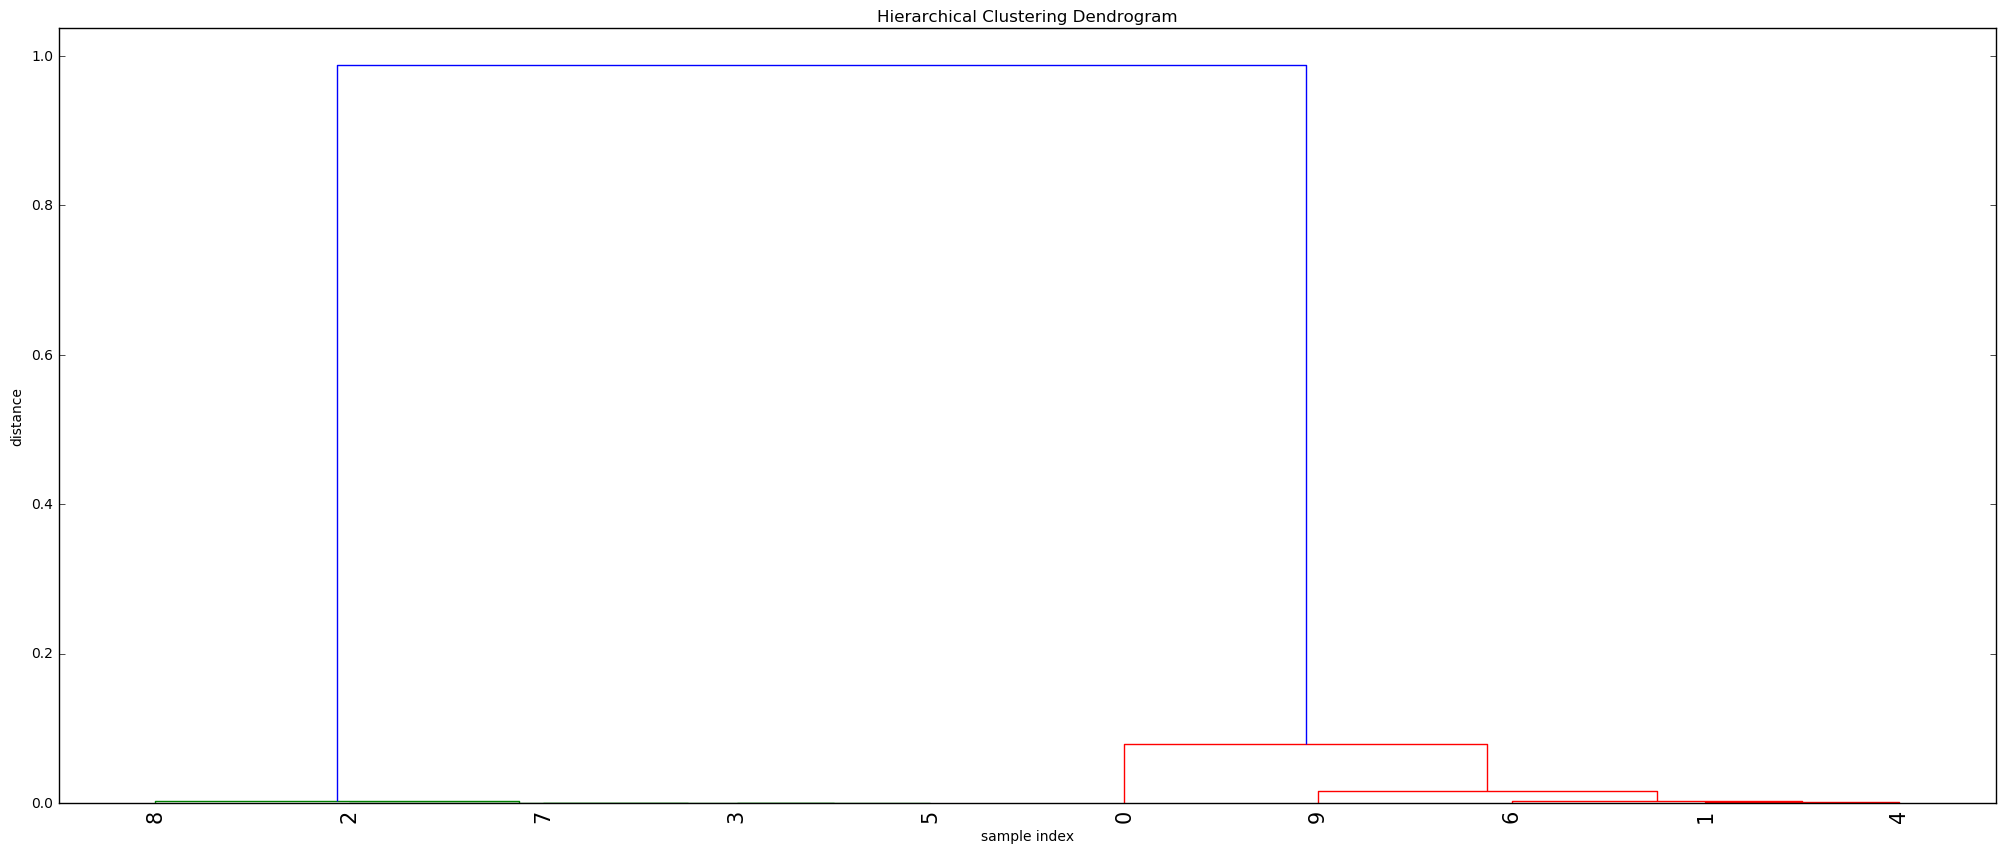

True | Pred | Sentence
 0    | 1    | ['tomato', 'share1', 'pear', 'tomato', 'apple']
 0    | 1    | ['pear', 'tomato', 'tomato', 'pear', 'strawberry', 'tomato', 'grape', 'apple', 'strawberry', 'pear', 'apple', 'strawberry']
 1    | 0    | ['share1', 'river', 'share1', 'lake', 'share1', 'share2', 'river', 'lake', 'lake', 'lake', 'hill', 'valley']
 1    | 0    | ['share2', 'mountain', 'lake', 'mountain', 'share1', 'hill', 'valley', 'valley', 'valley', 'valley', 'river', 'valley', 'mountain']
 0    | 1    | ['apple', 'tomato', 'tomato', 'share2', 'share2', 'apple', 'strawberry', 'tomato', 'pear']
 1    | 0    | ['river', 'hill', 'share2', 'share2', 'lake', 'share1', 'river', 'valley', 'hill', 'share1', 'lake', 'share1', 'valley']
 0    | 1    | ['share1', 'strawberry', 'grape', 'tomato', 'share2', 'share1', 'tomato', 'grape', 'share1', 'share1', 'share2']
 1    | 0    | ['lake', 'lake', 'share1', 'river', 'lake', 'share1', 'valley', 'lake', 'share1', 'share1', 'river']
 1    | 0    | ['m

In [25]:
clf_hac.evaluate(*get_rand_mixture())

In [27]:
def rand_evaluation(k=1000):
    accuracies = []
    for _ in range(k):
        _, acc = clf_hac.evaluate(*get_rand_mixture(), plot=False)
        accuracies.append(acc)
    print('Average clustering accuracy over {} samples = {}'.format(k, np.mean(accuracies)))

In [28]:
%%time

rand_evaluation()

Average clustering accuracy over 1000 samples = 0.9987
CPU times: user 54min 26s, sys: 6min 37s, total: 1h 1min 3s
Wall time: 22min 30s
